## Download the data from GWOSC

In [1]:
import os

for url in (
    'https://zenodo.org/record/6513631/files/IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5',
    'https://zenodo.org/record/5636816/files/o1%2Bo2%2Bo3_bbhpop_real%2Bsemianalytic-LIGO-T2100377-v2.hdf5',
    ):
    file = url.split('files/')[1].replace('%2B', '+')
    if not os.path.exists('./data/' + file):
        os.system(f'wget -P ./data/ {url}')

## Install popodds

In [2]:
#!pip install -U popodds

In [3]:
try:
    os.system('pip install -e ..')
except:
    os.system('pip install -U popodds')

Obtaining file:///home/ADF/mdm988/matt/code/popodds
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: popodds
    Found existing installation: popodds 0.5.3
    Uninstalling popodds-0.5.3:
      Successfully uninstalled popodds-0.5.3
  Running setup.py develop for popodds


In [169]:
import numpy as np
import h5py
from astropy.cosmology import Planck15
from scipy.interpolate import interp1d
from scipy.integrate import quad
import matplotlib.pyplot as plt
from kaydee import KDE
import popodds

## Population model

In [158]:
# We take power laws in m1 and q
# We assume the rest of the model matches the PE prior
# E.g., uniform spin mags, isotropic spin angles, etc.
# Thus those parts of the model cancel the PE prior in the Bayes factor

def powerlaw(x, lo, hi, slope):
    
    shape = x**slope
    norm = (slope + 1) / (hi**(slope + 1) - lo**(slope + 1))
    cut = (lo < x) * (x < hi)
    
    return shape * norm * cut

def mass_model(m1, q, m_min, m_max, m_slope, q_slope):
    
    p_m1 = powerlaw(m1, m_min, m_max, m_slope)
    p_q = powerlaw(q, m_min/m1, 1, q_slope)
    
    return p_m1 * p_q

In [174]:
# redshift p(z) ~ dV/dz / (1+z)
# We assume the redshift model equals the cosmological PE prior
# However, we do not know the normalization, i.e., the maximum redshift
# This won't matter for relative Bayes factors

class PowerlawRedshift:

    def __init__(self, z_min=0, z_max=1.9, z_pow=0):

        self.z_min = z_min
        self.z_max = z_max
        self.z_pow = z_pow
        
        # We interpolate dV/dz to speed it up
        zs = np.linspace(z_min, z_max, 1000)
        self.dVdz = interp1d(
            zs, Planck15.differential_comoving_volume(zs).value,
            )
        self.norm = quad(self.model, z_min, z_max)[0]

    def model(self, z):
        
        return self.dVdz(z) * (1 + z)**(self.z_pow - 1)

    def prob(self, z):

        return (self.z_min < z) * (z < self.z_max) * self.model(z) / self.norm

# Uniform volumetric merger rate in the source frame
redshift_model = PowerlawRedshift().prob

## GW150914 parameter estimation samples

In [149]:
# The posterior samples have been reweighted to a cosmological distance prior
file = './data/IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5'
with h5py.File(file, 'r') as h:
    
    pos = h['C01:IMRPhenomXPHM']['posterior_samples']
    m1 = pos['mass_1_source']
    q = pos['mass_ratio']
    m1z = pos['mass_1']
    m2z = pos['mass_2']
    z = pos['redshift'][:]
    
    pri = h['C01:IMRPhenomXPHM']['priors']['samples']
    m1z_pri = pri['mass_1'][:]
    m2z_pri = pri['mass_2'][:]
    
    # The prior samples do not use the cosmological distance prior...
    print(h['C01:IMRPhenomXPHM']['priors']['analytic']['luminosity_distance'][:])

[b"PowerLaw(alpha=2, minimum=10, maximum=10000, name='luminosity_distance', latex_label='$d_L$', unit='Mpc', boundary=None)"]


In [150]:
print(m1z.shape)
print(m1z_pri.shape)

(147634,)
(5000,)


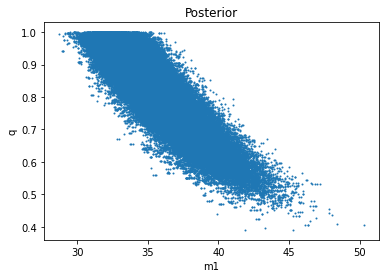

In [151]:
# The m1--q posterior

plt.scatter(m1, q, s=1)
plt.xlabel('m1')
plt.ylabel('q')
plt.title('Posterior');

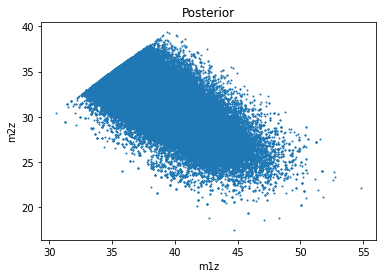

In [152]:
# The detector-frame m1--m2 posterior

plt.scatter(m1z, m2z, s=1)
plt.xlabel('m1z')
plt.ylabel('m2z')
plt.title('Posterior');

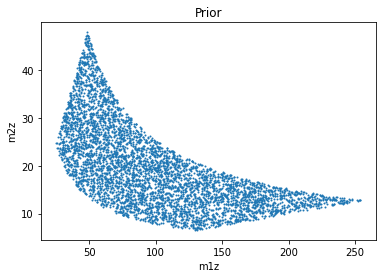

In [153]:
# The detector-frame m1--m2 prior
# As we can see, there are mass cuts in the (detector-frame) prior

plt.scatter(m1z_pri, m2z_pri, s=1)
plt.xlabel('m1z')
plt.ylabel('m2z')
plt.title('Prior');

In [171]:
# The Jacobian for (m1z, m2z, z) -> (m1, q, z) is m1(1+z)^2
# The prior p(m1z, m2z) is flat inside the cuts
# We assume a redshift model equal to the PE prior so it cancels

# We don't need the prior normalization when comparing two models as it cancels
# But we do need it if we just compare one model to the PE prior
# The Jacobian gives us the shape over the transformed PE prior

pri_at_pos_jacobian = m1 * (1 + z)**2

pri_at_pos_nonorm = lambda x: pri_at_pos_jacobian

In [175]:
# We can also estimate the normalized prior with a KDE fit to prior samples
# We will include mass and redshift here, unlike above

# This will take a few seconds because KDE and dV/dz evaluations are slow
pri_at_pos_kde_ = (
    KDE([m1z_pri, m2z_pri]).pdf([m1z, m2z]) *
    redshift_model(z) *
    pri_at_pos_jacobian
    )

pri_at_pos_kde = lambda x: pri_at_pos_kde_

## Without selection effects

In [176]:
# First let's use the unnormalized PE prior

# Define the astrophysical model
modelA = lambda x: mass_model(*x, m_min=5, m_max=50, m_slope=-2, q_slope=1)

# And a second one
modelB = lambda x: mass_model(*x, m_min=2, m_max=40, m_slope=-3, q_slope=0)

In [177]:
# Bayes factor between modelA and PE prior
# Incorrect! Because the PE prior is not normalized:

log_bf_nonorm = popodds.log_odds(modelA, prior_nonorm, [m1, q], log=False)
print('log BF_{A/PE} =', log_bf_nonorm)

# Bayes factor between modelA and modelB
# Note that the PE prior still enters the individal Bayes factors
# This is fine though, because the PE prior normalization cancels:

log_bfAB_nonorm = popodds.log_odds(
    modelA, prior_nonorm, [m1, q], log=False, second_model=modelB,
    )
print('log BF_{A/B} =', log_bfAB_nonorm)

log BF_{A/PE} = -8.576104358365143
log BF_{A/B} = 3.6935810829298408


/home/ADF/mdm988/matt/code/popodds/popodds/__init__.py:215: RuntimeWarning: divide by zero encountered in log
  model = np.log(model)


In [178]:
# Now let's use the normalized PE prior
# Since we included the redshift PE prior in pri_at_pos_kde,
# we must also include it in the population model

def modelA(x):
    
    m1, q, z = x
    p_m = mass_model(m1, q, m_min=5, m_max=50, m_slope=-2, q_slope=1)
    p_z = redshift_model(z)
    
    return p_m * p_z

def modelB(x):
    
    m1, q, z = x
    p_m = mass_model(m1, q, m_min=2, m_max=40, m_slope=-3, q_slope=0)
    p_z = redshift_model(z)
    
    return p_m * p_z

In [182]:
# Bayes factor between modelA and PE prior
# Now using the correctly normalized PE prior

log_bf_kde = popodds.log_odds(modelA, prior_kde, [m1, q, z], log=False)
print('log BF_{A/PE} =', log_bf_kde)

# Bayes factor between modelA and modelB
# This should be similar to log_bfAB_nonorm, up to errors from the KDE

log_bfAB_kde = popodds.log_odds(
    modelA, prior_kde, [m1, q, z], log=False, second_model=modelB,
    )
print('log BF_{A/B} =', log_bfAB_kde, 'cf.', log_bfAB_nonorm)

log BF_{A/PE} = -0.12239871657604695
log BF_{A/B} = 3.7013097795164622 cf. 3.6935810829298408


## With selection effects

In [185]:
# We compute population detection fractions by reweighting recovered injections
# First let's grab the recovered p(det|theta)=1 injections

cut_far = 1
cut_snr = 12

file = './data/o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5'
with h5py.File(file, 'r') as h:
    
    # Actually, we don't need to know the total (detectable + not detectable)
    # number of injections, becaues it cancels
    # n_total = h.attrs['total_generated']
    
    d = h['injections']
    
    ifars = np.max([d[par][:] for par in d if 'ifar' in par], axis=0)
    snrs = d['optimal_snr_net'][:]
    obs_runs = d['name'][:].astype(str)
    found = np.where(obs_runs == 'o3', ifars > 1/cut_far, snrs > cut_snr)
    
    m1_found = d['mass1_source'][:][found]
    m2_found = d['mass2_source'][:][found]
    s1x_found = d['spin1x'][:][found]
    s1y_found = d['spin1y'][:][found]
    s1z_found = d['spin1z'][:][found]
    s2x_found = d['spin2x'][:][found]
    s2y_found = d['spin2y'][:][found]
    s2z_found = d['spin2z'][:][found]
    z_found = d['redshift'][:][found]
        
    # See https://zenodo.org/record/5546676 for the injection distribution
    # sampling_pdf is the injected p(m1, m2) p(s1x, s1y, s1z) p(s2x, s2y, s2z) p(z)
    prior_found = d['sampling_pdf'][:][found]

In [186]:
# joint source-frame primary mass and mass ratio

pow_mass1 = -2.35
min_mass1 = 2
max_mass1 = 100
min_mass2 = 2
pow_mass2 = 1

def prior_inj_m(m1, m2):
    
    return (
        powerlaw(m1, min_mass1, max_mass1, pow_mass1) *
        powerlaw(m2, min_mass2, m1, pow_mass2)
        )

In [187]:
# cartesian spin

max_spin1 = 0.998
max_spin2 = 0.998

def prior_inj_s(sx, sy, sz, max_spin):
    
    ssq = sx**2 + sy**2 + sz**2
    
    return (ssq <= max_spin**2) / 4 / np.pi / ssq / max_spin

prior_inj_s1 = lambda *v: p_s(*v, max_spin1)
prior_inj_s2 = lambda *v: p_s(*v, max_spin2)

In [188]:
# redshift p(z) ~ dV/dz * (1+z)^(z_pow-1)

prior_inj_z = PowerlawRedshift(z_max=1.9, z_pow=1).prob

In [189]:
# Let's check the injection distributions
# see https://zenodo.org/record/5546676

my_prior_found = (
    p_m(m1_found, m2_found) *
    p_s1(s1x_found, s1y_found, s1z_found) *
    p_s2(s2x_found, s2y_found, s2z_found) *
    p_z(z_found)
    )

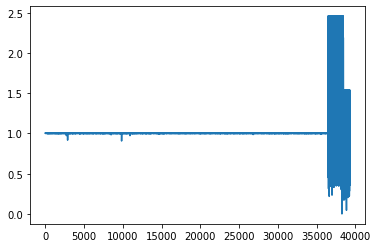

In [192]:
# The last ~5000 recovered injections have incorrect PDFs in the public data...
# And there's a few dodgy points in between

plt.plot(my_prior_found / prior_found);

In [195]:
# Also note that although the documentation says z_max=1
# (see https://zenodo.org/record/5546676),
# there is an injected redshift > z_max...

print(z_found.max())

# So let's exclude that point

m1_found = m1_found[z_found < z_max]
m2_found = m2_found[z_found < z_max]
z_found = z_found[z_found < z_max]

2.982684110794755


In [196]:
# To include selection effects we define a dictionary as follows

q_found = m2_found / m1_found

mass_jacobian = m1_found

detectable = dict(
    samples=[m1_found, q_found, z_found],
    prior=prior_inj_m(m1_found, m2_found) * mass_jacobian * prior_inj_z(z_found),
    )

In [199]:
m1, q, z

(array([17.39769745, 27.59049225, 34.87878799, ..., 39.44332118,
        51.90734739, 35.8333281 ]),
 array([0.78795855, 0.86417484, 0.85202945, ..., 0.75690546, 0.99145702,
        0.677695  ]),
 array([0.19250949, 0.3339659 , 0.98206556, ..., 0.41346643, 0.12487546,
        0.33013271]))

In [200]:
# Now compute the detection-conditioned Bayes factor between A and B

log_bfABdet_kde = popodds.log_odds(
    modelA, prior_kde, [m1, q, z], log=False, second_model=modelB,
    detectable=detectable,
    )
print('log BF_{A/B}_det =', log_bfABdet_kde)

ValueError: not enough values to unpack (expected 3, got 1)